In [1]:
# qnn_diagnostic.py
# Quantum Diagnostic Tool (QNN) — self-contained demo
# - 4-qubit parameterized circuit with feature embedding
# - Trains for 10 epochs on synthetic multi-disease labels
# - Vectorized batch inference over 50 patients
# - Matplotlib plots (train vs validation) for loss & accuracy

import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple

# ------------------------- Utility: quantum gates --------------------------
def Ry(theta: float) -> np.ndarray:
    c, s = np.cos(theta / 2.0), np.sin(theta / 2.0)
    return np.array([[c, -s], [s, c]], dtype=np.complex128)

def Rz(theta: float) -> np.ndarray:
    return np.array([[np.exp(-1j * theta / 2.0), 0.0],
                     [0.0, np.exp(1j * theta / 2.0)]], dtype=np.complex128)

I2 = np.eye(2, dtype=np.complex128)
X = np.array([[0,1],[1,0]], dtype=np.complex128)
Z = np.array([[1,0],[0,-1]], dtype=np.complex128)

def kronN(mats):
    out = np.array([[1.0+0j]])
    for m in mats:
        out = np.kron(out, m)
    return out

def single_qubit_op(op: np.ndarray, n_qubits: int, wire: int) -> np.ndarray:
    # wire index: 0 is leftmost (most-significant) qubit
    mats = []
    for i in range(n_qubits):
        mats.append(op if i == wire else I2)
    return kronN(mats)

def CNOT(n_qubits: int, control: int, target: int) -> np.ndarray:
    dim = 2**n_qubits
    U = np.zeros((dim, dim), dtype=np.complex128)
    for basis in range(dim):
        b = [(basis >> (n_qubits-1-i)) & 1 for i in range(n_qubits)]
        if b[control] == 1:
            b_new = b.copy()
            b_new[target] ^= 1
            new_idx = 0
            for i in range(n_qubits):
                new_idx = (new_idx << 1) | b_new[i]
            U[new_idx, basis] = 1.0
        else:
            U[basis, basis] = 1.0
    return U

def measure_Z_expectations(state_batch: np.ndarray, n_qubits: int, wires) -> np.ndarray:
    """Return expectation <Z> on given wires for each state in the batch.
    state_batch: shape (B, 2^n) complex
    returns: shape (B, len(wires))
    """
    B = state_batch.shape[0]
    res = np.zeros((B, len(wires)))
    probs = np.real(state_batch * np.conj(state_batch))  # (B, 2^n)
    basis_vals = np.arange(2**n_qubits)
    for wi, w in enumerate(wires):
        vals = 1.0 - 2.0 * ((basis_vals >> (n_qubits-1-w)) & 1)  # +1 for |0>, -1 for |1>
        res[:, wi] = (probs * vals[None, :]).sum(axis=1)
    return res

In [2]:
# ------------------------- QNN Model Definition ---------------------------
class QNN4:
    def __init__(self, n_qubits=4, n_outputs=3, seed=0):
        rng = np.random.default_rng(seed)
        self.n_qubits = n_qubits
        self.n_outputs = n_outputs
        # Trainable circuit angles after embedding (one Ry per qubit)
        self.alpha = rng.normal(scale=0.3, size=(n_qubits,))  # 4 params
        # Linear readout (from 4 expectation features to 3 diseases)
        self.W = rng.normal(scale=0.5, size=(n_outputs, n_qubits))
        self.b = rng.normal(scale=0.1, size=(n_outputs,))
        # Static entangling unitary (CNOT chain 0->1->2->3)
        self.U_ent = np.eye(2**n_qubits, dtype=np.complex128)
        for c, t in [(0,1),(1,2),(2,3)]:
            self.U_ent = CNOT(n_qubits, c, t) @ self.U_ent

    def forward_states(self, X: np.ndarray) -> np.ndarray:
        """Prepare/batch-evolve quantum states for inputs X.
        X shape: (B, 4) values mapped as Ry angles on each qubit.
        Returns state vectors of shape (B, 16)."""
        B = X.shape[0]
        n = self.n_qubits
        psi = np.zeros((B, 2**n), dtype=np.complex128)
        psi[:, 0] = 1.0 + 0j  # |0000>
        # Feature embedding Ry(x_i) on each qubit i
        for wire in range(n):
            new_psi = np.empty_like(psi)
            for i in range(B):
                Ui = single_qubit_op(Ry(X[i, wire]), n, wire)
                new_psi[i] = Ui @ psi[i]
            psi = new_psi
        # Entangle (same for all in batch)
        psi = (self.U_ent @ psi.T).T
        # Trainable Ry on each qubit
        for wire in range(n):
            new_psi = np.empty_like(psi)
            Ui = single_qubit_op(Ry(self.alpha[wire]), n, wire)
            for i in range(B):
                new_psi[i] = Ui @ psi[i]
            psi = new_psi
        return psi

    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Returns logits (B, 3) and features (B, 4=<Z> on qubits)"""
        psi = self.forward_states(X)  # (B, 16)
        feats = measure_Z_expectations(psi, self.n_qubits, wires=[0,1,2,3])  # (B,4)
        logits = feats @ self.W.T + self.b[None, :]
        return logits, feats

In [3]:
# ---------------------------- Data & Loss ---------------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def bce_logits(logits, targets, eps=1e-7):
    probs = sigmoid(logits)
    return -np.mean(targets*np.log(probs+eps) + (1-targets)*np.log(1-probs+eps))

def accuracy(logits, targets):
    preds = (sigmoid(logits) >= 0.5).astype(np.float64)
    return (preds == targets).mean()

def make_synthetic_dataset(B=50, seed=42):
    rng = np.random.default_rng(seed)
    # 4 biomarkers scaled to [0, pi]
    X = rng.uniform(0, np.pi, size=(B, 4))
    # Multi-label targets (3 diseases), incl. a rare label
    A = (X.mean(axis=1) < 1.4).astype(np.float64)                            # early-stage marker
    B_ = (np.abs(X[:,0] - X[:,2]) > 0.8).astype(np.float64)                 # interaction pattern
    C = (((X[:,1] > 1.2) & (X[:,1] < 1.35)) & ((X[:,3] > 1.0) & (X[:,3] < 1.15))).astype(np.float64)  # rare
    Y = np.stack([A, B_, C], axis=1)
    return X, Y


In [4]:
# --------------------------- Training (FD-GD) ------------------------------
def finite_difference_step(model: QNN4, Xb, Yb, lr=0.1, eps=1e-2):
    params = {'alpha': model.alpha, 'W': model.W, 'b': model.b}
    # Base loss
    logits, _ = model.forward(Xb)
    base_loss = bce_logits(logits, Yb)
    # Finite-difference gradient for each parameter
    for arr in params.values():
        it = np.nditer(arr, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = arr[idx]
            arr[idx] = orig + eps
            lp, _ = model.forward(Xb)
            loss_plus = bce_logits(lp, Yb)
            arr[idx] = orig - eps
            lm, _ = model.forward(Xb)
            loss_minus = bce_logits(lm, Yb)
            grad = (loss_plus - loss_minus) / (2*eps)
            arr[idx] = orig - lr * grad
            it.iternext()
    logits, _ = model.forward(Xb)
    return bce_logits(logits, Yb)


Epoch 01 | train_loss=0.6710 val_loss=0.7179 | train_acc=0.600 val_acc=0.433 | step_time=0.53s
Epoch 02 | train_loss=0.6628 val_loss=0.7077 | train_acc=0.617 val_acc=0.500 | step_time=0.54s
Epoch 03 | train_loss=0.6550 val_loss=0.6978 | train_acc=0.633 val_acc=0.500 | step_time=0.53s
Epoch 04 | train_loss=0.6474 val_loss=0.6883 | train_acc=0.642 val_acc=0.533 | step_time=0.52s
Epoch 05 | train_loss=0.6401 val_loss=0.6792 | train_acc=0.658 val_acc=0.533 | step_time=0.54s
Epoch 06 | train_loss=0.6331 val_loss=0.6703 | train_acc=0.675 val_acc=0.533 | step_time=0.52s
Epoch 07 | train_loss=0.6263 val_loss=0.6618 | train_acc=0.683 val_acc=0.533 | step_time=0.52s
Epoch 08 | train_loss=0.6198 val_loss=0.6536 | train_acc=0.708 val_acc=0.600 | step_time=0.50s
Epoch 09 | train_loss=0.6135 val_loss=0.6456 | train_acc=0.742 val_acc=0.667 | step_time=0.54s
Epoch 10 | train_loss=0.6074 val_loss=0.6379 | train_acc=0.758 val_acc=0.667 | step_time=0.52s

Parallel (vectorized) inference over 50 patients 

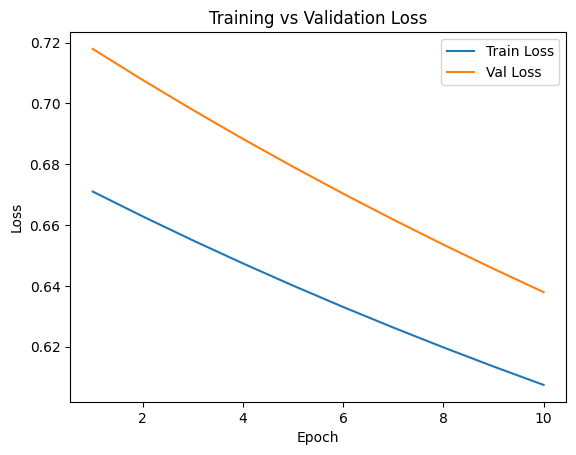

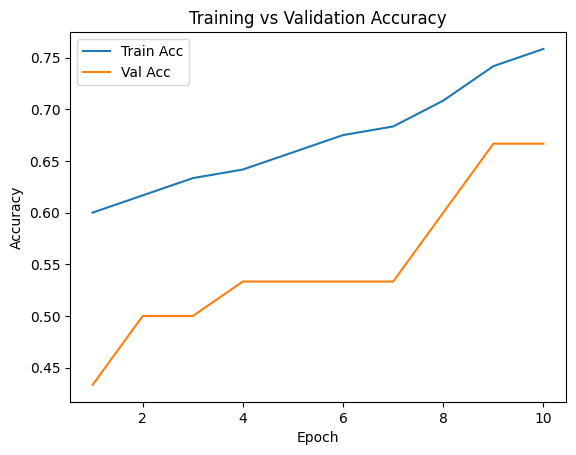

In [8]:
# ------------------------------ Demo Run -----------------------------------
def run_demo():
    X, Y = make_synthetic_dataset(B=50, seed=0)
    # Train/Val split (40/10)
    X_tr, Y_tr = X[:40], Y[:40]
    X_va, Y_va = X[40:], Y[40:]

    model = QNN4(n_qubits=4, n_outputs=3, seed=1)
    epochs = 10
    lr = 0.2

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss = finite_difference_step(model, X_tr, Y_tr, lr=lr, eps=1e-2)
        t1 = time.time()
        tr_logits, _ = model.forward(X_tr)
        va_logits, _ = model.forward(X_va)
        va_loss = bce_logits(va_logits, Y_va)
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        train_accs.append(accuracy(tr_logits, Y_tr))
        val_accs.append(accuracy(va_logits, Y_va))
        print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
              f"| train_acc={train_accs[-1]:.3f} val_acc={val_accs[-1]:.3f} "
              f"| step_time={t1-t0:.2f}s")

    # Vectorized "parallel" inference demo on all 50 patients
    t_vec0 = time.time()
    logits_vec, _ = model.forward(X)
    preds_vec = (sigmoid(logits_vec) >= 0.5).astype(np.float64)
    t_vec1 = time.time()

    # Naive loop inference (for comparison)
    t_loop0 = time.time()
    preds_loop = []
    for i in range(X.shape[0]):
        lgi, _ = model.forward(X[i:i+1])
        preds_loop.append((sigmoid(lgi) >= 0.5).astype(np.float64))
    preds_loop = np.vstack(preds_loop)
    t_loop1 = time.time()

    print("\nParallel (vectorized) inference over 50 patients took: "
          f"{(t_vec1 - t_vec0)*1000:.1f} ms")
    print("Naive loop inference over 50 patients took: "
          f"{(t_loop1 - t_loop0)*1000:.1f} ms")
    # ---------------------- Plots: convergence & stability -----------------
    # Plot 1: Loss
    plt.figure()
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot 2: Accuracy
    plt.figure()
    plt.plot(range(1, epochs+1), train_accs, label="Train Acc")
    plt.plot(range(1, epochs+1), val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()

    return model

if __name__ == "__main__":
    run_demo()
